In [ ]:
# --- Papermill parameters ---
from pathlib import Path
from corp_speech_risk_dataset.shared.discovery import find_stage_files

DATA_ROOT = Path(r"/Users/jakedugan/Documents/corporate_media_risk/corp_speech_risk_dataset/extracted_quotes")  # absolute path
STAGE_MAP  = find_stage_files(DATA_ROOT)
print('→ DATA_ROOT:', DATA_ROOT)
print({k: len(v) for k, v in STAGE_MAP.items()})
assert STAGE_MAP, f'STAGE_MAP empty – does {DATA_ROOT} contain *_stage*.jsonl ?'


→ DATA_ROOT: /Users/jakedugan/Documents/corporate_media_risk/corp_speech_risk_dataset/extracted_quotes
{1: 16544, 0: 16544, 2: 5115, 4: 5008, 3: 5115}


In [2]:
from pathlib import Path
print('Notebook CWD:', Path.cwd())

Notebook CWD: /Users/jakedugan/Documents/corporate_media_risk/corp_speech_risk_dataset/notebooks/reports


# Quote Extraction Pipeline Visualization

This notebook loads the JSONL outputs from each stage of the quote extraction pipeline, combines them into a single DataFrame, and provides visualizations to analyze the process.

In [3]:
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to sys.path to allow for local module imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")

sns.set_theme(style="whitegrid")

pandas version: 2.3.0
matplotlib version: 3.10.3


## 1. Configuration & Parameters

Define paths to the data files and set visualization parameters.

In [4]:
import polars as pl
import duckdb
import holoviews as hv, hvplot.pandas
import datashader as ds
from datashader import transfer_functions as tf
hv.extension('bokeh')
# Visualization settings
SCORE_NULL_PLACEHOLDER = -1.0
MAX_SPEAKERS = 10
MAX_QUOTES = 3
# pd.set_option('display.max_rows', 20)
# pd.set_option('display.min_rows', 10)


## 2. Utility Functions

Helper functions to load and prepare the data for analysis.

In [5]:
def load_stage(stage: int) -> pl.DataFrame:
    paths = STAGE_MAP.get(stage, [])
    if not paths:
        return pl.DataFrame()
    # Properly quote each path as a plain string
    joined = ', '.join(f"'{str(p)}'" for p in paths)
    q = f"SELECT *, {stage} AS stage FROM read_json_auto([{joined}])"
    return duckdb.query(q).pl()   # ~2-3× faster than pandas.read_json

def prepare_dataframe(dfs: list[pl.DataFrame]) -> pl.DataFrame:
    if not any(df.height > 0 for df in dfs):
        return pl.DataFrame()
    full = pl.concat(dfs)
    full = full.with_columns([
        pl.col('speaker').fill_null('<none>'),
        pl.col('score').fill_null(SCORE_NULL_PLACEHOLDER)
    ])
    return full.sort(['stage', 'speaker', 'score'], descending=[False, False, True])

## 3. Data Loading & Preparation

Load data from all four stages into a single pandas DataFrame.

In [6]:
import polars as pl
import duckdb
# 1. Define the target schema
TARGET_SCHEMA = {
    'doc_id':  pl.Utf8,
    'text':    pl.Utf8,
    'context': pl.Utf8,
    'speaker': pl.Utf8,
    'score':   pl.Float64,
    'urls':    pl.List(pl.Utf8),
    'stage':   pl.Int64,
    '_src':    pl.Utf8,
}

# 2. Guaranteed Polars loader
def load_stage(stage: int) -> pl.DataFrame:
    paths = STAGE_MAP.get(stage, [])
    if not paths:
        return pl.DataFrame()
    joined = ', '.join(f"'{p}'" for p in paths)
    arrow_tbl = duckdb.query(f"SELECT * FROM read_json_auto([{joined}])").arrow()
    df = pl.from_arrow(arrow_tbl)
    # drop any existing 'stage' and inject our literal
    return df.drop('stage').with_columns(pl.lit(stage, pl.Int64).alias('stage'))

# 3. Align helper (using with_columns)
def align_schema(df: pl.DataFrame, schema: dict[str, pl.DataType]) -> pl.DataFrame:
    for col, dtype in schema.items():
        if col not in df.columns:
            df = df.with_columns(pl.lit(None, dtype=dtype).alias(col))
        else:
            df = df.with_columns(df[col].cast(dtype).alias(col))
    return df.select(list(schema.keys()))

# 4. Load, align, concat
dfs = [load_stage(s) for s in sorted(STAGE_MAP)]
dfs = [df for df in dfs if df.height > 0]
aligned = [align_schema(df, TARGET_SCHEMA) for df in dfs]
full_df = pl.concat(aligned, how='vertical') if aligned else pl.DataFrame()
print('Combined DataFrame shape:', full_df.shape)
display(full_df.head(10)) if full_df.height > 0 else print('DataFrame is empty. Please run `make run` first to generate the data.')

Combined DataFrame shape: (336748, 8)


doc_id,text,context,speaker,score,urls,stage,_src
str,str,str,str,f64,list[str],i64,str
"""doc_435084163_text""",""" Case 3:25-cv-05070…",null,null,null,[],0,"""results/courtlistener_v11/3:25…"
"""doc_434228010_text""",""" Case 3:25-cv-05070-…",null,null,null,[],0,"""results/courtlistener_v11/3:25…"
"""doc_3657977_text""",""",,a v_ Case 3:12-cv-01326-HES-…",null,null,null,[],0,"""results/courtlistener_v11/3:12…"
"""doc_3657957_text""","""Case 3:12-cv-01326-HES-JBT Doc…",null,null,null,[],0,"""results/courtlistener_v11/3:12…"
"""doc_3657942_text""","""Case 3:12-cv-01326-HES-JBT Doc…",null,null,null,[],0,"""results/courtlistener_v11/3:12…"
"""doc_2298491_text""","""\OOO\]O\U`I-|>b~)[\.)»-¢ [\.)…",null,null,null,[],0,"""results/courtlistener_v11/3:08…"
"""doc_2298483_text""",""" \] 9 10 11 12 13 14 15 16 …",null,null,null,[],0,"""results/courtlistener_v11/3:08…"
"""doc_2298488_text""","""\OOO\]O\LA-|>b-Jl\)»-¢ [\)[\)…",null,null,null,[],0,"""results/courtlistener_v11/3:08…"
"""doc_2298485_text""","""10 11' 12 13 14 15 16 1…",null,null,null,[],0,"""results/courtlistener_v11/3:08…"


## 4. Stage-By-Stage Inspection

Let's examine the output of each pipeline stage. We'll print a formatted summary of the quotes found at each step.

In [7]:
def print_stage_overview(df: pl.DataFrame):
    """Iterates through the dataframe and prints a formatted summary."""
    if df.is_empty():
        print('No data to display.')
        return
    for stage in df['stage'].unique().to_list():
        stage_df = df.filter(pl.col('stage') == stage)
        print(f"\n\n{'='*10} Stage {stage} {'='*10}")
        for speaker in stage_df['speaker'].unique().to_list():
            grp = stage_df.filter(pl.col('speaker') == speaker)
            count = grp.height
            print(f"\n-- Speaker: {speaker!r} ({count} rows) --")
            top5 = grp.sort('score', reverse=True).head(5)
            for row in top5.iter_rows(named=True):
                score = row['score']
                score_str = f"[{score:.2f}]" if score >= 0 else "[---]"
                text = row['text'].replace('\n', ' ')
                if len(text) > 120:
                    text = text[:117] + '...'
                print(f"  • {score_str} {text}")


## 5. Cross-Stage Comparison & Visualizations

Now let's visualize the filtering process across stages.

### 5.1 Quote Survival Rate by Stage

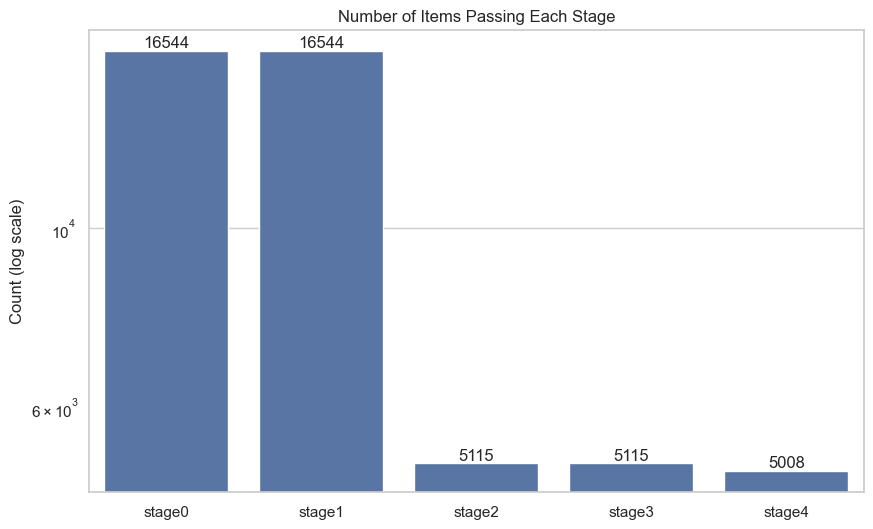

In [8]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
# Polars-native check for emptiness
if not full_df.is_empty():
    stage_counts = (
        full_df
        .group_by('stage')
        .agg(pl.col('doc_id').n_unique().alias('count'))
        .sort('stage')
    )
    labels = [f'stage{s}' for s in stage_counts['stage'].to_list()]
    counts = stage_counts['count'].to_list()
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=labels, y=counts)
    ax.set_title('Number of Items Passing Each Stage')
    ax.set_ylabel('Count (log scale)')
    ax.set_yscale('log')
    ax.bar_label(ax.containers[0])
    plt.show()
else:
    print('No data to plot.')

### 5.2 Speaker Distribution in Final Stage

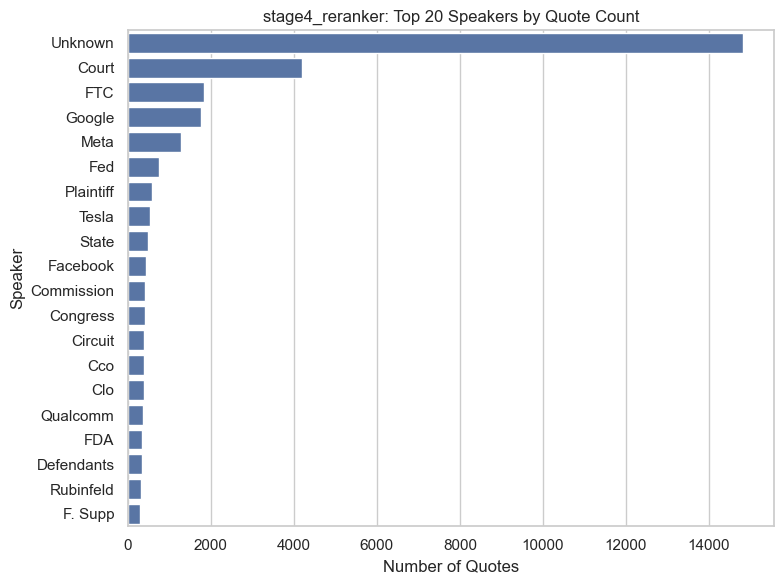

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# 5.2: Final-stage speaker counts
if not full_df.is_empty():
    final = full_df.filter(pl.col('stage') == 4)
    if not final.is_empty():
        speaker_counts = (
            final
            .group_by('speaker')
            .agg(pl.len().alias('n_quotes'))
            .sort('n_quotes', descending=True)
            .head(20)
        )
        df_sp = speaker_counts.to_pandas()
        plt.figure(figsize=(8, 6))
        sns.barplot(data=df_sp, y='speaker', x='n_quotes', orient='h')
        plt.title('stage4_reranker: Top 20 Speakers by Quote Count')
        plt.xlabel('Number of Quotes')
        plt.ylabel('Speaker')
        plt.tight_layout()
        plt.show()
    else:
        print('No quotes survived to the final stage.')
else:
    print('No data to plot.')

### 5.3 Score Distribution in Final Stage

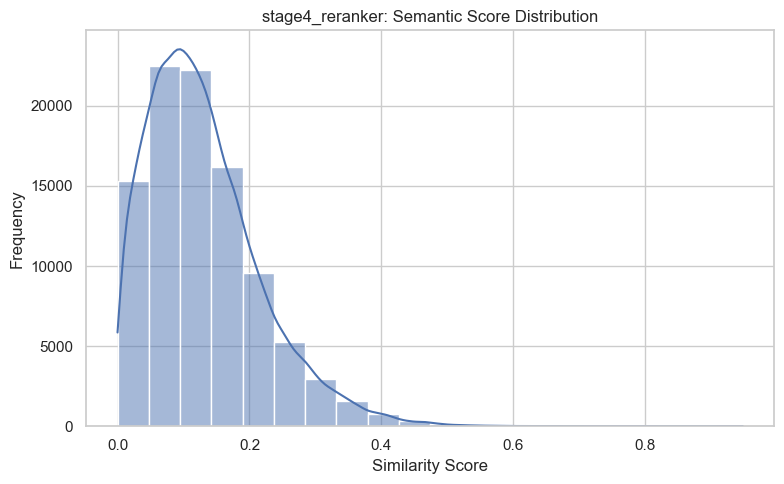

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# 5.3: Score histogram for final-stage quotes
if not full_df.is_empty():
    with_scores = (
       full_df
       .filter((pl.col('stage') == 4) & (pl.col('score') >= 0))
       .select('score')
    )
    if not with_scores.is_empty():
        scores = with_scores.to_series().to_list()
        plt.figure(figsize=(8, 5))
        sns.histplot(scores, bins=20, kde=True)
        plt.title('stage4_reranker: Semantic Score Distribution')
        plt.xlabel('Similarity Score')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print('No scored quotes in the final stage to plot.')
else:
    print('No data to plot.')

## 6. Conclusion

This notebook provides a detailed, stage-by-stage analysis of the quote extraction pipeline. The visualizations highlight the filtering effectiveness at each step, from raw text to final, semantically-scored quotes.